<a href="https://colab.research.google.com/github/Nishanthan15me104/Mini-Projects/blob/main/langchain_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [ ]:
# for linux
# !apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# !brew install poppler tesseract libmagic

In [ ]:
# pip install python-magic-bin


  Using cached python_magic_bin-0.4.14-py2.py3-none-win_amd64.whl.metadata (710 bytes)
Using cached python_magic_bin-0.4.14-py2.py3-none-win_amd64.whl (409 kB)


In [ ]:
# %pip install -Uq "unstructured[all-docs]" pillow lxml pillow
# %pip install -Uq chromadb tiktoken
# %pip install -Uq langchain langchain-community langchain-openai langchain-groq
# %pip install -Uq python_dotenv


Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4-python3-runtime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.72.0rc1 requires protobuf<7.0dev,>=6.30.0, but you have protobuf 5.29.4 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

# keys for the services we will use

# os.environ["OPENAI_API_KEY"] = "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"
# os.environ["GROQ_API_KEY"] = "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"
os.environ["GROQ_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "sk-..."
os.environ["LANGCHAIN_TRACING_V2"] = "true"


In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Now you can access the key like this:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# if groq_api_key:
#     print(f"DEBUG: GROQ_API_KEY loaded: {groq_api_key[:5]}...{groq_api_key[-5:]}") # Prints first/last 5 chars
# else:
#     print("DEBUG: GROQ_API_KEY not found in environment!")

# Or you can set it directly if you prefer, but it's already loaded into os.environ
# os.environ["GROQ_API_KEY"] = groq_api_key # This line would be redundant if you loaded it
                   

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [3]:
# import shutil

# print("pdftoppm:", shutil.which("pdftoppm"))
# print("tesseract:", shutil.which("tesseract"))
# print("poppler:", shutil.which("poppler"))



pdftoppm: C:\Program Files\poppler-24.08.0\Library\bin\pdftoppm.EXE
tesseract: C:\Program Files\Tesseract-OCR\tesseract.EXE
poppler: None


In [ ]:
# pip install python-poppler
# !pip install "unstructured[pdf]" unstructured-inference

In [3]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image", "Table"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

c:\Users\nis44\anaconda3\RAG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

to check chunks with table


In [ ]:
# chunks_with_tables = []
# chunks_with_images = []

# for i, chunk in enumerate(chunks):
#     if str(type(chunk)) == "<class 'unstructured.documents.elements.CompositeElement'>":
#         sub_elements = chunk.metadata.orig_elements
        
#         has_table = False
#         has_image = False
        
#         for el in sub_elements:
#             if str(type(el)) == "<class 'unstructured.documents.elements.Table'>":
#                 has_table = True
#                 tables.append(el)
#             elif str(type(el)) == "<class 'unstructured.documents.elements.Image'>":
#                 has_image = True
#                 images_b64.append(el.metadata.image_base64)
#             else:
#                 texts.append(el)
        
#         if has_table:
#             chunks_with_tables.append(i)
#         if has_image:
#             chunks_with_images.append(i)
#     else:
#         # You can also track if non-composite chunks have tables/images if needed
#         pass

# print(f"Chunks containing tables: {chunks_with_tables}")
# print(f"Chunks containing images: {chunks_with_images}")



NameError: name 'texts' is not defined

In [6]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [7]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[5].metadata.orig_elements
chunk_images = [el for el in elements if "<class 'unstructured.documents.elements.Table'>" in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Table',
 'element_id': '41fa8245-70cc-439c-bb00-242e71c691c6',
 'text': 'Layer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)',
 'metadata': {'detection_class_prob': 0.9258710145950317,
  'coordinates': {'points': ((np.float64(324.7924499511719),
     np.float64(313.3711853027344)),
    (np.float64(324.7924499511719), np.float64(518.0281982421875)),
    (np.float64(1356.664306640625), np.float64(518.0281982421875)),
    (np.float64(1356.664306640625), np.float64(313.3711853027344))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-05-21T16:40:06',
  'text_as_html': '<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n

### Separate extracted elements into tables, text, and images

In [8]:
tables = []
texts = []
images_b64 = []

for chunk in chunks:
    if str(type(chunk)) == "<class 'unstructured.documents.elements.CompositeElement'>":
        # Get all original elements inside the composite
        sub_elements = chunk.metadata.orig_elements

        for el in sub_elements:
            if str(type(el)) == "<class 'unstructured.documents.elements.Table'>":
                tables.append(el)
            elif str(type(el)) == "<class 'unstructured.documents.elements.Image'>":
                images_b64.append(el.metadata.image_base64)
            else:
                texts.append(el)  # NarrativeText, Title, etc.


In [ ]:
# for i, images_b64 in enumerate(tables):
#     print(f"\n--- Table {i+1} ---")
#     print(table.text)



--- Table 1 ---


NameError: name 'table' is not defined

In [ ]:
# # separate tables from texts
# tables = []
# texts = []

# for chunk in chunks:
#     if "Table" in str(type(chunk)):
#         tables.append(chunk)

#     if "CompositeElement" in str(type((chunk))):
#         texts.append(chunk)

In [10]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

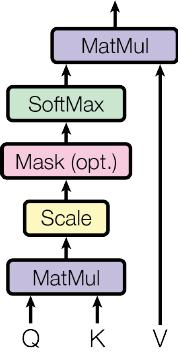

In [12]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[1])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [ ]:
# %pip install -Uq langchain-groq
# %pip install -Uq langchain_openai
# pip install langchain-huggingface 
# pip install langchain-google-genai
# pip install google-generativeai

Note: you may need to restart the kernel to use updated packages.


In [13]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [14]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="meta-llama/llama-4-scout-17b-16e-instruct")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [18]:
import time
from more_itertools import chunked

# Summarize text chunks in batches of 10
text_summaries = []

for batch in chunked(texts, 10):  # Process 10 text chunks at a time
    summaries = summarize_chain.batch(
        [{"element": str(t)} for t in batch],
        {"max_concurrency": 1}
    )
    text_summaries.extend(summaries)
    time.sleep(2)  # Wait 10 seconds between batches

# Prepare table HTMLs
tables_html = [table.metadata.text_as_html for table in tables]

# Summarize table chunks in batches of 10
table_summaries = []

for batch in chunked(tables_html, 10):  # Process 10 table HTMLs at a time
    summaries = summarize_chain.batch(
        [{"element": str(html)} for html in batch],
        {"max_concurrency": 1}
    )
    table_summaries.extend(summaries)
    time.sleep(2)  # Wait 10 seconds between batches


In [ ]:
# # Summarize text
# text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# # Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables]
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [16]:
len(chunks)

9

to check no. of chunks and tables

In [15]:
print(f"Number of text chunks: {len(texts)}")
tables_html = [table.metadata.text_as_html for table in tables]
print(f"Number of table chunks: {len(tables_html)}")


Number of text chunks: 167
Number of table chunks: 3


In [19]:
text_summaries

['The element is Attention Is All You Need.',
 'Ashish Vaswani works at Google Brain, his email is avaswani@google.com.',
 'Noam Shazeer is affiliated with Google Brain, and his email is noam@google.com.',
 'Niki Parmar is listed as an element, denoted with an asterisk.',
 'The element is associated with Google Research and the email address nikip@google.com.',
 'Jakob Uszkoreit works at Google Research, his email is usz@google.com.',
 'Llion Jones works at Google Research, his email is llion@google.com.',
 'Aidan N. Gomez is affiliated with the University of Toronto and can be contacted at aidan@cs.toronto.edu.',
 'Łukasz Kaiser works at Google Brain and his email is lukaszkaiser@google.com.',
 'Illia Polosukhin∗ ‡ is an element with a single value. \n\n Value: Illia Polosukhin∗ ‡',
 'The email address is illia.polosukhin@gmail.com.',
 'No information to summarize.',
 'The Transformer, a new network architecture based solely on attention mechanisms, outperforms existing models in mach

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [20]:
from langchain_google_genai  import GoogleGenerativeAI

In [ ]:
# import google.generativeai as genai

# import os

# # Make sure your GOOGLE_API_KEY is set as an environment variable
# # os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY" # Uncomment and replace if you prefer to set it directly in code (less secure)

# if "GOOGLE_API_KEY" not in os.environ:
#     print("Error: GOOGLE_API_KEY environment variable not set.")
#     print("Please set your GOOGLE_API_KEY before running this script.")
# else:
#     genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

#     print("Fetching available models...")
#     for m in genai.list_models():
#         if "generateContent" in m.supported_generation_methods:
#             print(f"Model ID: {m.name}, Supported Methods: {m.supported_generation_methods}")
#             # You might also check m.vision for models that support image input
#             # if m.vision:
#             #     print(f"  (Supports Vision)")

In [21]:
from langchain_google_genai import ChatGoogleGenerativeAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]
llm = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct", temperature=0.1)
prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | llm | StrOutputParser()


image_summaries = chain.batch(images)


In [22]:
image_summaries

['The image presents a detailed diagram of the Transformer architecture, a type of neural network designed for natural language processing tasks. The diagram is divided into two main sections: the encoder and the decoder.\n\n**Encoder:**\n\n*   The encoder takes in a sequence of input tokens, which are embedded into a higher-dimensional space using an **Input Embedding** layer.\n*   The embedded inputs are then added to **Positional Encoding**, which provides information about the position of each token in the sequence.\n*   The resulting vector is fed into a series of identical layers, each consisting of two sub-layers:\n    *   **Multi-Head Attention**: This sub-layer applies self-attention to the input sequence, allowing the model to attend to different parts of the input sequence simultaneously.\n    *   **Feed Forward**: This sub-layer applies a feed-forward neural network to the output of the multi-head attention sub-layer.\n*   The output of each layer is passed through an **Add

In [24]:
print(image_summaries[0])

The image presents a detailed diagram of the Transformer architecture, a type of neural network designed for natural language processing tasks. The diagram is divided into two main sections: the encoder and the decoder.

**Encoder:**

*   The encoder takes in a sequence of input tokens, which are embedded into a higher-dimensional space using an **Input Embedding** layer.
*   The embedded inputs are then added to **Positional Encoding**, which provides information about the position of each token in the sequence.
*   The resulting vector is fed into a series of identical layers, each consisting of two sub-layers:
    *   **Multi-Head Attention**: This sub-layer applies self-attention to the input sequence, allowing the model to attend to different parts of the input sequence simultaneously.
    *   **Feed Forward**: This sub-layer applies a feed-forward neural network to the output of the multi-head attention sub-layer.
*   The output of each layer is passed through an **Add & Norm** l

## Load data and summaries to vectorstore

### Create the vectorstore

In [26]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever


hf_embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=hf_embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

C:\Users\nis44\AppData\Local\Temp\ipykernel_35272\2574808026.py:12: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=hf_embeddings)


### Load the summaries and link the to the original data

In [27]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [28]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [29]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

Acknowledgements We are grateful to Nal Kalchbrenner and Stephan Gouws for their fruitful comments, corrections and inspiration.

--------------------------------------------------------------------------------
[17] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In ICLR, 2015.

--------------------------------------------------------------------------------
[3] Denny Britz, Anna Goldie, Minh-Thang Luong, and Quoc V. Le. Massive exploration of neural machine translation architectures. CoRR, abs/1703.03906, 2017.

--------------------------------------------------------------------------------
Jakob Uszkoreit∗ Google Research usz@google.com

--------------------------------------------------------------------------------


## RAG pipeline

In [31]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct", temperature=0.1)
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct", temperature=0.1)
        | StrOutputParser()
    )
)

In [ ]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a function that maps a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, with the weights determined by a compatibility function that measures how well the query aligns with each key.

In mathematical terms, the attention function can be expressed as:

\[ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V \]

Here, \(Q\) represents the queries, \(K\) the keys, and \(V\) the values. The dot products of the queries and keys are scaled by the square root of the dimension of the keys (\(d_k\)) to prevent large values that could push the softmax function into regions with small gradients. This attention mechanism allows the model to focus on different parts of the input sequence when producing an output, enhancing its ability to handle dependencies and context within the data. 

Additionally, multi-head attention extends th

In [32]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: MultiHead(Q,K,V ) = Concat(head1,...,headh)W O where headi = Attention(QW Q i ,KW K i ,V W V i ). Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.


Context:
MultiHead(Q,K,V ) = Concat(head1,...,headh)W O where headi = Attention(QW Q i ,KW K i ,V W V i )
Page number:  5

--------------------------------------------------

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
Page number:  4

--------------------------------------------------

The Transformer uses multi-head attention in three different ways:
Page number:  5

--------------------------------------------------

Multi-Head Attention
Page number:  4

--------------------------------------------------



## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)